# Stage 3

Through out this notebook, we are going to focus on three statistics:

- The average rate of new cases per week
- The maximum number of new cases in one week
- The ration between cases and deaths

All of these will be normalized with the population


In [1]:
FIRST_DATE = '2020-06-28'
LAST_DATE = '2020-12-27'
STATES = ['NC', 'SC', 'AL', 'CA', 'TX', 'NY']
FACTOR = 1000 # for normalisation
PICTURE_HEIGHT = 400
PICTURE_WIDTH = 1000

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Image
import os

if not os.path.exists("images"):
    os.mkdir("images")

raw_cases = pd.read_csv("../Team/covid_confirmed_usafacts.csv")
raw_deaths = pd.read_csv("../Team/covid_deaths_usafacts.csv")
county_population = pd.read_csv("../Team/covid_county_population_usafacts.csv")

## Part I

Let's begin with the average new cases per week. For that we first normalize by population, then we differentiate the dataset to get the change in total cases.



In [3]:
raw_cases = raw_cases.merge(county_population[['countyFIPS','population']], on='countyFIPS')
cases = raw_cases.drop(raw_cases[raw_cases.population == 0].index)
for col in cases.columns:
    if FIRST_DATE <= col <= LAST_DATE:
        cases[col] = cases[col] / cases['population'] * FACTOR

raw_deaths = raw_deaths.merge(county_population[['countyFIPS','population']], on='countyFIPS')
deaths = raw_deaths.drop(raw_cases[raw_deaths.population == 0].index)
for col in deaths.columns:
    if FIRST_DATE <= col <= LAST_DATE:
        deaths[col] = deaths[col] / deaths['population'] * FACTOR

In [4]:
selected_date_columns = [col for col in cases.columns if FIRST_DATE <= col <= LAST_DATE]
additional_columns = ["countyFIPS", "County Name", "State", "StateFIPS"]
selected_columns = additional_columns + selected_date_columns[0::7]
selected_cases = cases[selected_columns]
nc_cases = selected_cases.loc[selected_cases['State'] == 'NC']

selected_deaths = deaths[selected_columns]
nc_deaths = selected_deaths.loc[selected_deaths['State'] == 'NC']

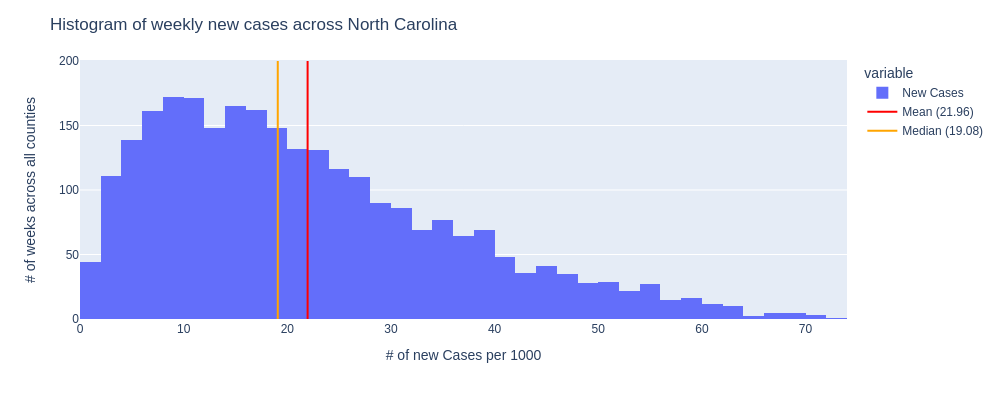

In [5]:
data = np.reshape(nc_cases[selected_date_columns[0::7]].to_numpy(), -1)
fig = px.histogram(data)

mean = np.mean(data)
fig.add_shape(go.layout.Shape(type='line', x0=mean, x1=mean, y0=0, y1=200, line=dict(color='red', width=2)))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', name=f'Mean ({mean:.2f})', line=dict(color='red', width=2)))


median = np.median(data)
fig.add_shape(go.layout.Shape(type='line', x0=median, x1=median, y0=0, y1=200, line=dict(color='orange', width=2)))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', name=f'Median ({median:.2f})', line=dict(color='orange', width=2)))

for trace in fig.data:
    if trace.name == '0':
        trace.name = 'New Cases'

fig.update_layout(
    title='Histogram of weekly new cases across North Carolina',
    xaxis=dict(title=f'# of new Cases per {FACTOR}'),
    yaxis=dict(title='# of weeks across all counties'),
    showlegend=True,
    width=PICTURE_WIDTH,
    height=PICTURE_HEIGHT
)

fig.write_image("images/histo-cases.png")
Image(filename="images/histo-cases.png")

In [6]:
print(f"The variance is {np.var(data)}")
print(f"The skewness is {stats.skew(data)}")
print(f"The kurtosis is {stats.kurtosis(data)}")

The variance is 208.7437899166838
The skewness is 0.8401691414226925
The kurtosis is 0.1810543779046978


The histogram is unimodal, and is skewed to the left.


Let's compare this to other states


In [7]:
def getCasesArray(state):
    data = selected_cases.loc[selected_cases['State'] == state].copy()
    return np.reshape(data[selected_date_columns[0::7]].to_numpy(), -1)

def getDeathsArray(state):
    data = selected_deaths.loc[selected_deaths['State'] == state].copy()
    return np.reshape(data[selected_date_columns[0::7]].to_numpy(), -1)

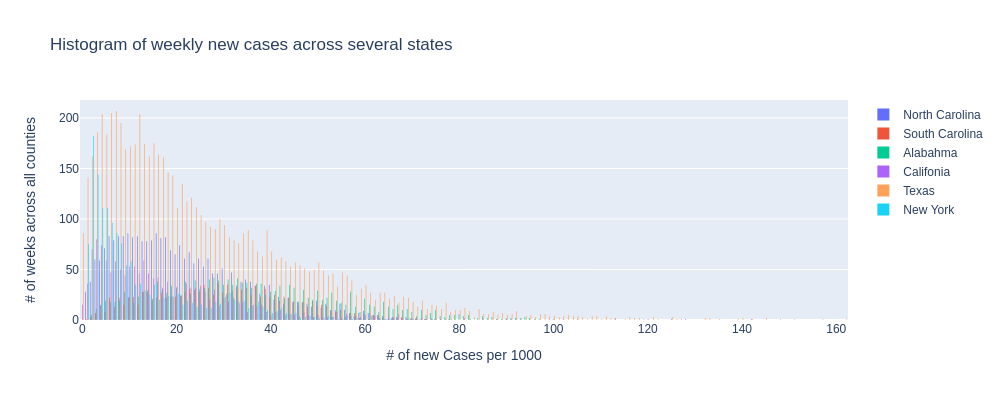

In [8]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=getCasesArray('NC'), name='North Carolina'))
fig.add_trace(go.Histogram(x=getCasesArray('SC'), name='South Carolina'))
fig.add_trace(go.Histogram(x=getCasesArray('AL'), name='Alabahma'))
fig.add_trace(go.Histogram(x=getCasesArray('CA'), name='Califonia'))
fig.add_trace(go.Histogram(x=getCasesArray('TX'), name='Texas'))
fig.add_trace(go.Histogram(x=getCasesArray('NY'), name='New York'))



fig.update_layout(
    title='Histogram of weekly new cases across several states',
    xaxis=dict(title=f'# of new Cases per {FACTOR}'),
    yaxis=dict(title='# of weeks across all counties'),
    showlegend=True,
    width=PICTURE_WIDTH,
    height=PICTURE_HEIGHT
)

fig.write_image("images/histo-states.png")
Image(filename="images/histo-states.png")

Over all, all distribution are unimodal and skewed to the left. However, Texas sticks out with it's sheer number. We have to keep in mind that the data is not normalized over the number of counties in a given state. Knowing that, distrubutions that are more flat are more concerning, as that implies that covid was spreading there fast. An Example would Alabahma. New York has a very dense concentration in the lower numbers, this means that covid was not spreading fast there.


## Part II

We are going to use North Carolina again



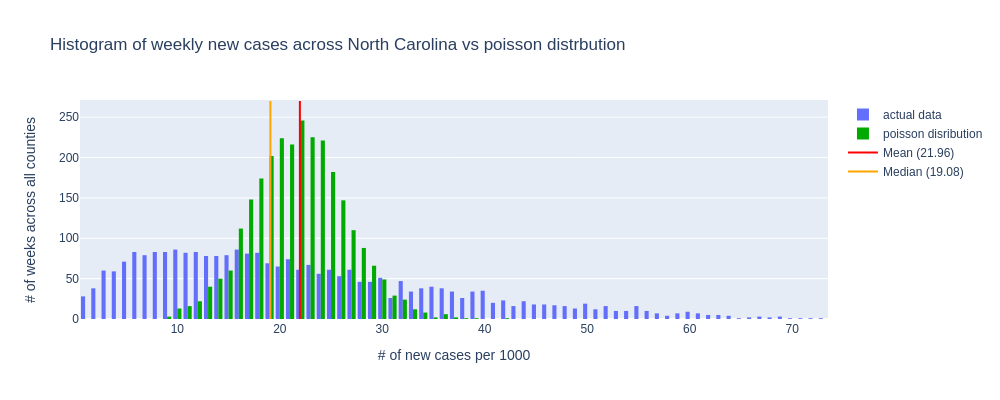

In [9]:
data = np.reshape(nc_cases[selected_date_columns[0::7]].to_numpy(), -1)

fig = go.Figure()
fig.add_trace(go.Histogram(x=data, name='actual data'))
fig.add_trace(go.Histogram(x=np.random.poisson(np.mean(data), len(data)), name='poisson disribution', marker_color='#00AA00'))

mean = np.mean(data)
fig.add_shape(go.layout.Shape(type='line', x0=mean, x1=mean, y0=0, y1=270, line=dict(color='red', width=2)))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', name=f'Mean ({mean:.2f})', line=dict(color='red', width=2)))


median = np.median(data)
fig.add_shape(go.layout.Shape(type='line', x0=median, x1=median, y0=0, y1=270, line=dict(color='orange', width=2)))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', name=f'Median ({median:.2f})', line=dict(color='orange', width=2)))

fig.update_layout(
    title='Histogram of weekly new cases across North Carolina vs poisson distrbution',
    xaxis=dict(title=f'# of new cases per {FACTOR}'),
    yaxis=dict(title='# of weeks across all counties'),
    showlegend=True,
    width=PICTURE_WIDTH,
    height=PICTURE_HEIGHT
)

fig.write_image("images/poisson-cases.png")
Image(filename="images/poisson-cases.png")

We can see that the actual data cannot be represented as a poisson distribution. That is because the varience is not equal to the mean. Which shows in the difference of mean and median.


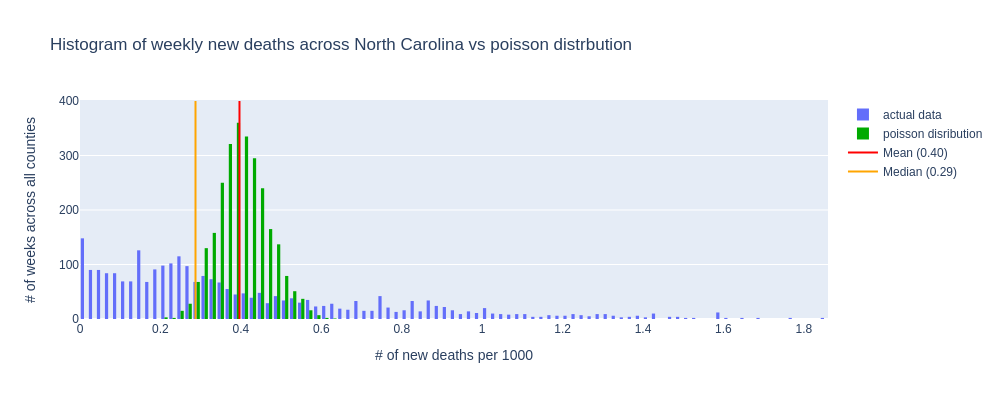

In [10]:
data = np.reshape(nc_deaths[selected_date_columns[0::7]].to_numpy(), -1)


fig = go.Figure()
fig.add_trace(go.Histogram(x=data, name='actual data'))
fig.add_trace(go.Histogram(x=(np.random.poisson(np.mean(data) *100, len(data)) /100), name='poisson disribution', marker_color='#00AA00'))

mean = np.mean(data)
fig.add_shape(go.layout.Shape(type='line', x0=mean, x1=mean, y0=0, y1=400, line=dict(color='red', width=2)))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', name=f'Mean ({mean:.2f})', line=dict(color='red', width=2)))


median = np.median(data)
fig.add_shape(go.layout.Shape(type='line', x0=median, x1=median, y0=0, y1=400, line=dict(color='orange', width=2)))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', name=f'Median ({median:.2f})', line=dict(color='orange', width=2)))

fig.update_layout(
    title='Histogram of weekly new deaths across North Carolina vs poisson distrbution',
    xaxis=dict(title=f'# of new deaths per {FACTOR}'),
    yaxis=dict(title='# of weeks across all counties'),
    showlegend=True,
    width=PICTURE_WIDTH,
    height=PICTURE_HEIGHT
)


fig.write_image("images/poisson-cases.png")
Image(filename="images/poisson-cases.png")

The effect is even stronger with more skewed deaths statistic. Let's have a look at the other states


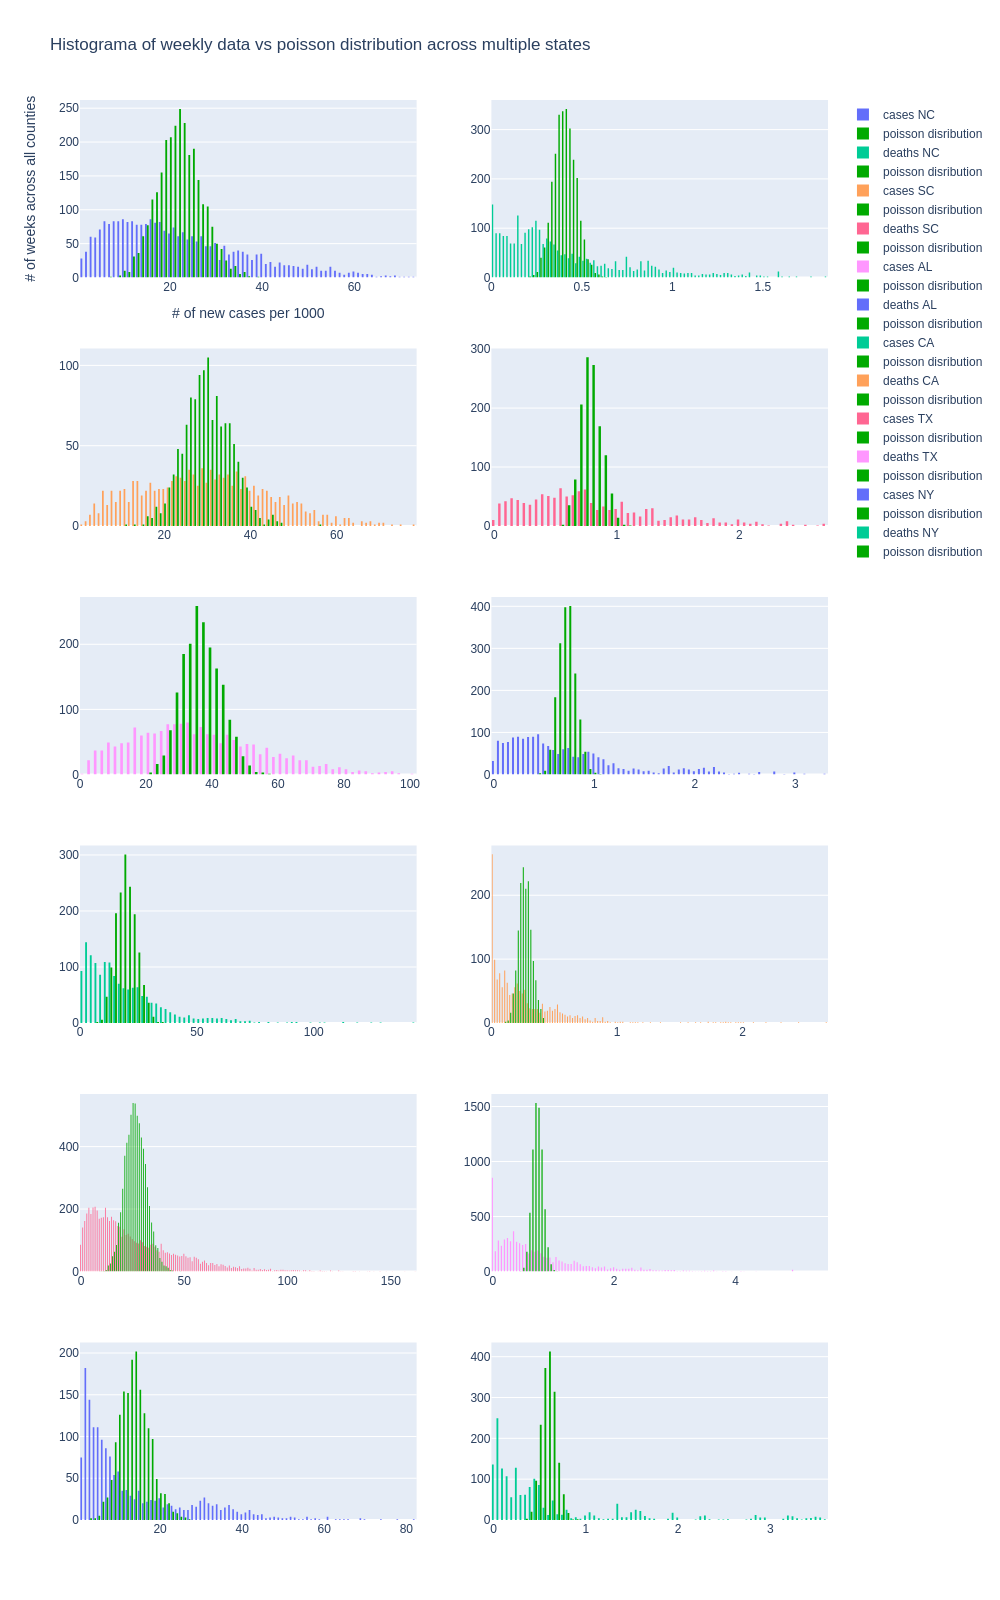

In [11]:
fig = make_subplots(rows=6, cols=2)

for i, state in enumerate(STATES):
    data = getCasesArray(state)
    fig.add_trace(go.Histogram(x=data, name='cases '+state), row=(i+1), col=1)
    fig.add_trace(go.Histogram(x=np.random.poisson(np.mean(data), len(data)), name='poisson disribution', marker_color='#00AA00'), row=(i+1), col=1)
    
    data = getDeathsArray(state)
    fig.add_trace(go.Histogram(x=data, name='deaths '+state), row=(i+1), col=2)
    fig.add_trace(go.Histogram(x=(np.random.poisson(np.mean(data) * 100, len(data))/100), name='poisson disribution', marker_color='#00AA00'), row=(i+1), col=2)

fig.update_layout(
    title='Histograma of weekly data vs poisson distribution across multiple states',
    xaxis=dict(title=f'# of new cases per {FACTOR}'),
    yaxis=dict(title='# of weeks across all counties'),
    showlegend=True,
    width=PICTURE_WIDTH,
    height=(PICTURE_HEIGHT *4)
)
    
fig.write_image("images/poisson-cases.png")
Image(filename="images/poisson-cases.png")

We can see that the actual data cannot be represented as a poisson distribution. That is because the variance is not equal to the mean. Thus the poisson distribution should not be assumed for the distribution of cases or deaths.



## Part III



In [12]:
housing = pd.read_csv("./data/ACSDP1Y2022.DP04-Data.csv", low_memory=False)
economics = pd.read_csv("./data/ACSDP1Y2022.DP03-Data.csv", low_memory=False)
housing['GEO_ID'] = pd.to_numeric(housing['GEO_ID'].str.slice(start=9))
economics['GEO_ID'] = pd.to_numeric(economics['GEO_ID'].str.slice(start=9))

to compare individual variables, we need a single indicator for the spread of covid. We'll focus on the average number of new cases a week and the maximum spread in one week.


In [13]:
selected_cases = selected_cases.merge(economics, left_on='countyFIPS', right_on='GEO_ID').merge(housing, left_on='countyFIPS', right_on='GEO_ID').merge(county_population[['population', 'countyFIPS']], left_on='countyFIPS', right_on='countyFIPS')
selected_cases['average'] = selected_cases[selected_date_columns[0::7]].mean(axis=1)
selected_cases['max'] = selected_cases[selected_date_columns[0::7]].max(axis=1)
selected_cases.head()


,countyFIPS,County Name,State,StateFIPS,2020-06-28,2020-07-05,2020-07-12,2020-07-19,2020-07-26,2020-08-02,...,DP04_0142PM,DP04_0142PMA,DP04_0143PE,DP04_0143PEA,DP04_0143PM,DP04_0143PMA,Unnamed: 1146,population,average,max
0,1003,Baldwin County,AL,1,2.575773,3.946531,5.796608,8.676994,12.130769,14.437765,...,9.2,NaN,(X),(X),(X),(X),NaN,223234,25.904059,57.450926
1,1015,Calhoun County,AL,1,2.156595,3.186479,4.630078,6.909907,9.797104,13.907839,...,8.8,NaN,(X),(X),(X),(X),NaN,113605,33.573770,81.264029
2,1043,Cullman County,AL,1,4.560214,5.491357,7.461083,9.812816,11.651227,14.062649,...,14.3,NaN,(X),(X),(X),(X),NaN,83768,30.095909,80.603572
3,1049,DeKalb County,AL,1,7.607009,10.179967,13.661852,18.234447,21.170976,23.939703,...,12.6,NaN,(X),(X),(X),(X),NaN,71513,42.264266,94.038846
4,1051,Elmore County,AL,1,9.715672,11.538130,13.372902,15.774114,18.323092,20.256376,...,9.9,NaN,(X),(X),(X),(X),NaN,81209,34.875718,73.809553


Let's check the realtion between average house hold size and covid spread


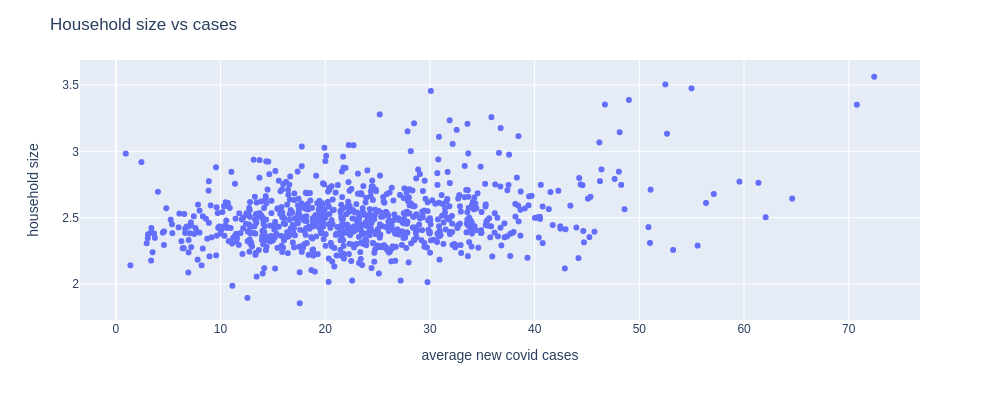

In [14]:
fig = px.scatter(x=selected_cases['average'], y=(selected_cases['population']  / (selected_cases['DP04_0002E'].astype(float))))
fig.update_layout(
    title='Household size vs cases',
    xaxis=dict(title=f'average new covid cases'),
    yaxis=dict(title=f'household size'),
    showlegend=True,
    width=PICTURE_WIDTH,
    height=PICTURE_HEIGHT
)

fig.write_image("images/cases-housing.png")
Image(filename="images/cases-housing.png")

In [15]:
print(f"The correlation of household size is {np.corrcoef(selected_cases['average'],selected_cases['population']  / (selected_cases['DP04_0002E'].astype(float)))[0, 1]}")


The correlation of household size is 0.277828419859136


Let's check some other varaibles from the housing and economics dataset


0.08106336532189166


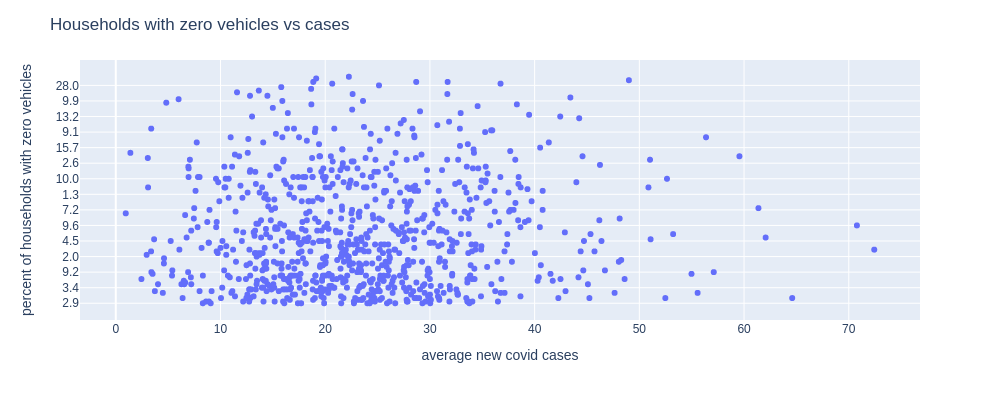

In [16]:
print(np.corrcoef(selected_cases['average'],selected_cases['DP04_0058PE'].astype(float))[0, 1])
fig = px.scatter(x=selected_cases['average'], y=selected_cases['DP04_0058PE'])
fig.update_layout(
    title='Households with zero vehicles vs cases',
    xaxis=dict(title=f'average new covid cases'),
    yaxis=dict(title=f'percent of households with zero vehicles'),
    showlegend=True,
    width=PICTURE_WIDTH,
    height=PICTURE_HEIGHT
)

fig.write_image("images/cases-vehicle.png")
Image(filename="images/cases-vehicle.png")

0.11276115691267607


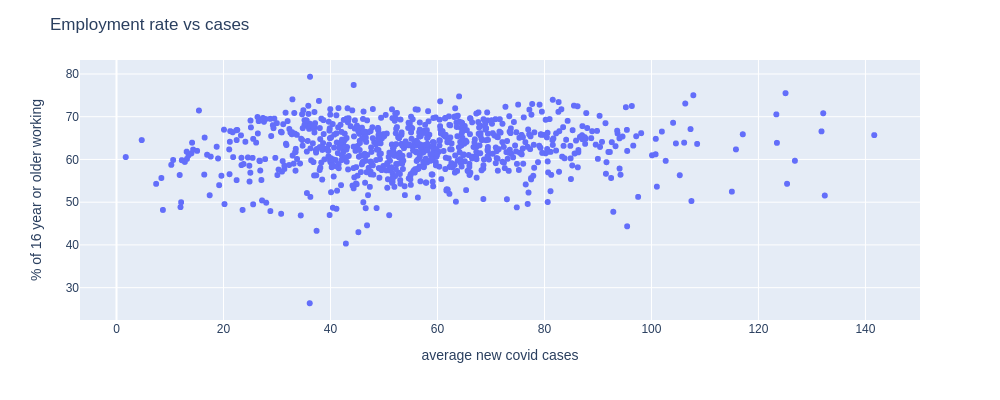

In [17]:
print(np.corrcoef(selected_cases['max'],(selected_cases['DP03_0002E'].astype(float)/selected_cases['DP03_0001E'].astype(float)))[0, 1])
fig = px.scatter(x=selected_cases['max'], y=(100 * selected_cases['DP03_0002E'].astype(float)/selected_cases['DP03_0001E'].astype(float)))
fig.update_layout(
    title='Employment rate vs cases',
    xaxis=dict(title=f'average new covid cases'),
    yaxis=dict(title=f'% of 16 year or older working'),
    showlegend=True,
    width=PICTURE_WIDTH,
    height=PICTURE_HEIGHT
)

fig.write_image("images/cases-employment.png")
Image(filename="images/cases-employment.png")

0.17242015943941838


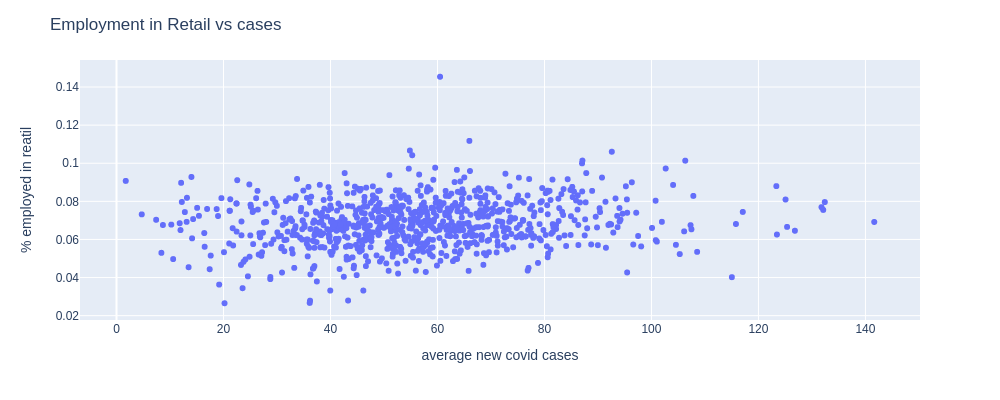

In [18]:
selected_cases['DP03_0037E'] = pd.to_numeric(selected_cases['DP03_0037E'], errors='coerce')
data = selected_cases.dropna(subset=['DP03_0037E'])
print(np.corrcoef(data['max'],(data['DP03_0037E'].astype(float) / data['DP03_0001E'].astype(float)))[0, 1])
fig = px.scatter(x=data['max'], y=(data['DP03_0037E'].astype(float)/data['DP03_0001E'].astype(float)))
fig.update_layout(
    title='Employment in Retail vs cases',
    xaxis=dict(title=f'average new covid cases'),
    yaxis=dict(title=f'% employed in reatil'),
    showlegend=True,
    width=PICTURE_WIDTH,
    height=PICTURE_HEIGHT
)

fig.write_image("images/cases-retail.png")
Image(filename="images/cases-retail.png")

-0.23924435962550658


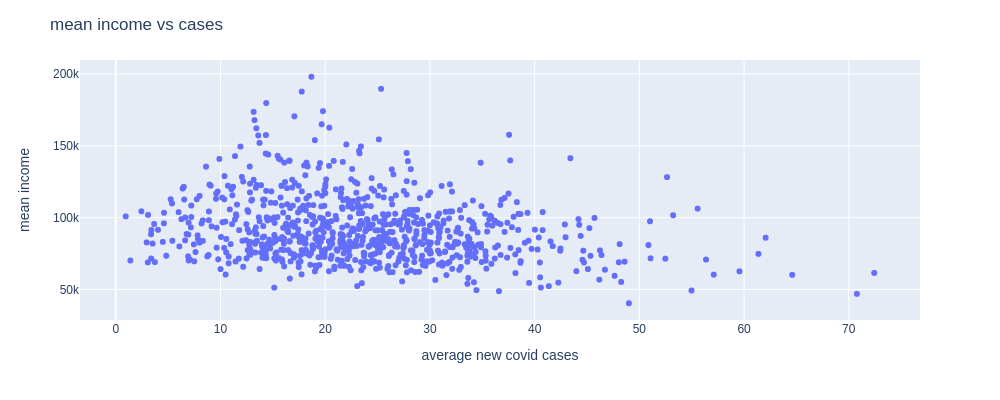

In [19]:

print(np.corrcoef(selected_cases['average'],(selected_cases['DP03_0086E'].astype(float)))[0, 1])
fig = px.scatter(x=selected_cases['average'], y=(selected_cases['DP03_0086E'].astype(float)))
fig.update_layout(
    title='mean income vs cases',
    xaxis=dict(title=f'average new covid cases'),
    yaxis=dict(title=f'mean income'),
    showlegend=True,
    width=PICTURE_WIDTH,
    height=PICTURE_HEIGHT
)

fig.write_image("images/cases-income.png")
Image(filename="images/cases-income.png")

## Part IV

With most of these Variable we have low correlation. I hypothesize that covid was a society\-wide phenomenon, disregarding economic and social factors. In particular I want to answer the following questions:

- Does an increased average household size lead to more cases?
- Does decreased mobility lead to fewer cases? \(based on the number of vehicles\)
- Does increased mean income lead to a lower mortality rate?

